In [25]:
import jax
import os
import sys
from tqdm.notebook import tqdm
os.environ['TF_FORCE_UNIFIED_MEMORY'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '2.0'
TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

In [2]:
print(f'Running with {jax.local_devices()[0].device_kind} GPU')

Running with Tesla T4 GPU


In [3]:
from alphafold.notebooks import notebook_utils

In [4]:
sequence_1 = 'MAAHKGAEHHHKAAEHHEQAAKHHHAAAEHHEKGEHEQAAHHADTAYAHHKHAEEHAAQAAKHDAEHHAPKPH'

In [5]:
input_sequences = (sequence_1,)

In [6]:
is_prokaryote = False  #@param {type:"boolean"}

MIN_SINGLE_SEQUENCE_LENGTH = 16
MAX_SINGLE_SEQUENCE_LENGTH = 2500
MAX_MULTIMER_LENGTH = 2500

In [7]:
sequences, model_type_to_use = notebook_utils.validate_input(
    input_sequences=input_sequences,
    min_length=MIN_SINGLE_SEQUENCE_LENGTH,
    max_length=MAX_SINGLE_SEQUENCE_LENGTH,
    max_multimer_length=MAX_MULTIMER_LENGTH)

Using the single-chain model.


In [8]:
# --- Python imports ---
import collections
import copy
from concurrent import futures
import json
import random

from urllib import request
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import py3Dmol

from alphafold.model import model
from alphafold.model import config
from alphafold.model import data

from alphafold.data import feature_processing
from alphafold.data import msa_pairing
from alphafold.data import parsers
from alphafold.data import pipeline
from alphafold.data import pipeline_multimer
from alphafold.data.tools import jackhmmer

from alphafold.common import protein

from alphafold.relax import relax
from alphafold.relax import utils

from IPython import display
from ipywidgets import GridspecLayout
from ipywidgets import Output

In [9]:
# Color bands for visualizing plddt
PLDDT_BANDS = [(0, 50, '#FF7D45'),
               (50, 70, '#FFDB13'),
               (70, 90, '#65CBF3'),
               (90, 100, '#0053D6')]

# --- Find the closest source ---
test_url_pattern = 'https://storage.googleapis.com/alphafold-colab{:s}/latest/uniref90_2021_03.fasta.1'
ex = futures.ThreadPoolExecutor(3)
def fetch(source):
  request.urlretrieve(test_url_pattern.format(source))
  return source
fs = [ex.submit(fetch, source) for source in ['', '-europe', '-asia']]
source = None
for f in futures.as_completed(fs):
  source = f.result()
  ex.shutdown()
  break

In [15]:
JACKHMMER_BINARY_PATH = '/home/studio-lab-user/.conda/pkgs/hmmer-3.3.2-h1b792b2_1/bin/jackhmmer'
DB_ROOT_PATH = f'https://storage.googleapis.com/alphafold-colab{source}/latest/'
# The z_value is the number of sequences in a database.
MSA_DATABASES = [
    {'db_name': 'uniref90',
     'db_path': f'{DB_ROOT_PATH}uniref90_2021_03.fasta',
     'num_streamed_chunks': 59,
     'z_value': 135_301_051},
    {'db_name': 'smallbfd',
     'db_path': f'{DB_ROOT_PATH}bfd-first_non_consensus_sequences.fasta',
     'num_streamed_chunks': 17,
     'z_value': 65_984_053},
    {'db_name': 'mgnify',
     'db_path': f'{DB_ROOT_PATH}mgy_clusters_2019_05.fasta',
     'num_streamed_chunks': 71,
     'z_value': 304_820_129},
]

In [16]:
# Search UniProt and construct the all_seq features only for heteromers, not homomers.
if model_type_to_use == notebook_utils.ModelType.MULTIMER and len(set(sequences)) > 1:
  MSA_DATABASES.extend([
      # Swiss-Prot and TrEMBL are concatenated together as UniProt.
      {'db_name': 'uniprot',
       'db_path': f'{DB_ROOT_PATH}uniprot_2021_03.fasta',
       'num_streamed_chunks': 98,
       'z_value': 219_174_961 + 565_254},
  ])

In [17]:
TOTAL_JACKHMMER_CHUNKS = sum([cfg['num_streamed_chunks'] for cfg in MSA_DATABASES])

MAX_HITS = {
    'uniref90': 10_000,
    'smallbfd': 5_000,
    'mgnify': 501,
    'uniprot': 50_000,
}

In [18]:
def get_msa(fasta_path):
  """Searches for MSA for the given sequence using chunked Jackhmmer search."""

  # Run the search against chunks of genetic databases (since the genetic
  # databases don't fit in Colab disk).
  raw_msa_results = collections.defaultdict(list)
  with tqdm(total=TOTAL_JACKHMMER_CHUNKS, bar_format=TQDM_BAR_FORMAT) as pbar:
    def jackhmmer_chunk_callback(i):
      pbar.update(n=1)

    for db_config in MSA_DATABASES:
      db_name = db_config['db_name']
      pbar.set_description(f'Searching {db_name}')
      jackhmmer_runner = jackhmmer.Jackhmmer(
          binary_path=JACKHMMER_BINARY_PATH,
          database_path=db_config['db_path'],
          get_tblout=True,
          num_streamed_chunks=db_config['num_streamed_chunks'],
          streaming_callback=jackhmmer_chunk_callback,
          z_value=db_config['z_value'])
      # Group the results by database name.
      raw_msa_results[db_name].extend(jackhmmer_runner.query(fasta_path))

  return raw_msa_results


Getting MSA for sequence 1


  0%|          | 0/147 [elapsed: 00:00 remaining: ?]

58 unique sequences found in uniref90 for sequence 1
110 unique sequences found in smallbfd for sequence 1
9 unique sequences found in mgnify for sequence 1

173 unique sequences found in total for sequence 1



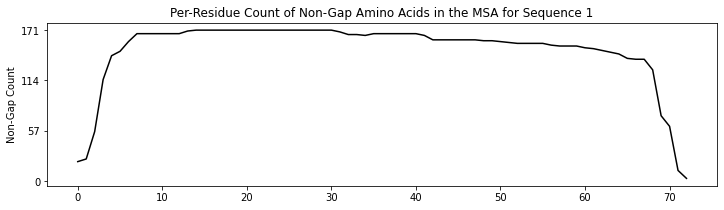

In [19]:
features_for_chain = {}
raw_msa_results_for_sequence = {}
for sequence_index, sequence in enumerate(sequences, start=1):
  print(f'\nGetting MSA for sequence {sequence_index}')

  fasta_path = f'target_{sequence_index}.fasta'
  with open(fasta_path, 'wt') as f:
    f.write(f'>query\n{sequence}')

  # Don't do redundant work for multiple copies of the same chain in the multimer.
  if sequence not in raw_msa_results_for_sequence:
    raw_msa_results = get_msa(fasta_path=fasta_path)
    raw_msa_results_for_sequence[sequence] = raw_msa_results
  else:
    raw_msa_results = copy.deepcopy(raw_msa_results_for_sequence[sequence])

  # Extract the MSAs from the Stockholm files.
  # NB: deduplication happens later in pipeline.make_msa_features.
  single_chain_msas = []
  uniprot_msa = None
  for db_name, db_results in raw_msa_results.items():
    merged_msa = notebook_utils.merge_chunked_msa(
        results=db_results, max_hits=MAX_HITS.get(db_name))
    if merged_msa.sequences and db_name != 'uniprot':
      single_chain_msas.append(merged_msa)
      msa_size = len(set(merged_msa.sequences))
      print(f'{msa_size} unique sequences found in {db_name} for sequence {sequence_index}')
    elif merged_msa.sequences and db_name == 'uniprot':
      uniprot_msa = merged_msa

  notebook_utils.show_msa_info(single_chain_msas=single_chain_msas, sequence_index=sequence_index)

  # Turn the raw data into model features.
  feature_dict = {}
  feature_dict.update(pipeline.make_sequence_features(
      sequence=sequence, description='query', num_res=len(sequence)))
  feature_dict.update(pipeline.make_msa_features(msas=single_chain_msas))
  # We don't use templates in AlphaFold Colab notebook, add only empty placeholder features.
  feature_dict.update(notebook_utils.empty_placeholder_template_features(
      num_templates=0, num_res=len(sequence)))

  # Construct the all_seq features only for heteromers, not homomers.
  if model_type_to_use == notebook_utils.ModelType.MULTIMER and len(set(sequences)) > 1:
    valid_feats = msa_pairing.MSA_FEATURES + (
        'msa_uniprot_accession_identifiers',
        'msa_species_identifiers',
    )
    all_seq_features = {
        f'{k}_all_seq': v for k, v in pipeline.make_msa_features([uniprot_msa]).items()
        if k in valid_feats}
    feature_dict.update(all_seq_features)

  features_for_chain[protein.PDB_CHAIN_IDS[sequence_index - 1]] = feature_dict

In [20]:
# Do further feature post-processing depending on the model type.
if model_type_to_use == notebook_utils.ModelType.MONOMER:
  np_example = features_for_chain[protein.PDB_CHAIN_IDS[0]]

elif model_type_to_use == notebook_utils.ModelType.MULTIMER:
  all_chain_features = {}
  for chain_id, chain_features in features_for_chain.items():
    all_chain_features[chain_id] = pipeline_multimer.convert_monomer_features(
        chain_features, chain_id)

  all_chain_features = pipeline_multimer.add_assembly_features(all_chain_features)

  np_example = feature_processing.pair_and_merge(
      all_chain_features=all_chain_features, is_prokaryote=is_prokaryote)

  # Pad MSA to avoid zero-sized extra_msa.
  np_example = pipeline_multimer.pad_msa(np_example, min_num_seq=512)

In [21]:
run_relax = True  #@param {type:"boolean"}

# --- Run the model ---
if model_type_to_use == notebook_utils.ModelType.MONOMER:
  model_names = config.MODEL_PRESETS['monomer'] + ('model_2_ptm',)
elif model_type_to_use == notebook_utils.ModelType.MULTIMER:
  model_names = config.MODEL_PRESETS['multimer']

output_dir = 'prediction'
os.makedirs(output_dir, exist_ok=True)

plddts = {}
ranking_confidences = {}
pae_outputs = {}
unrelaxed_proteins = {}

In [26]:
with tqdm(total=len(model_names) + 1, bar_format=TQDM_BAR_FORMAT) as pbar:
  for model_name in model_names:
    pbar.set_description(f'Running {model_name}')

    cfg = config.model_config(model_name)
    if model_type_to_use == notebook_utils.ModelType.MONOMER:
      cfg.data.eval.num_ensemble = 1
    elif model_type_to_use == notebook_utils.ModelType.MULTIMER:
      cfg.model.num_ensemble_eval = 1
    params = data.get_model_haiku_params(model_name, './data')
    model_runner = model.RunModel(cfg, params)
    processed_feature_dict = model_runner.process_features(np_example, random_seed=0)
    prediction = model_runner.predict(processed_feature_dict, random_seed=random.randrange(sys.maxsize))

    mean_plddt = prediction['plddt'].mean()

    if model_type_to_use == notebook_utils.ModelType.MONOMER:
      if 'predicted_aligned_error' in prediction:
        pae_outputs[model_name] = (prediction['predicted_aligned_error'],
                                   prediction['max_predicted_aligned_error'])
      else:
        # Monomer models are sorted by mean pLDDT. Do not put monomer pTM models here as they
        # should never get selected.
        ranking_confidences[model_name] = prediction['ranking_confidence']
        plddts[model_name] = prediction['plddt']
    elif model_type_to_use == notebook_utils.ModelType.MULTIMER:
      # Multimer models are sorted by pTM+ipTM.
      ranking_confidences[model_name] = prediction['ranking_confidence']
      plddts[model_name] = prediction['plddt']
      pae_outputs[model_name] = (prediction['predicted_aligned_error'],
                                 prediction['max_predicted_aligned_error'])

    # Set the b-factors to the per-residue plddt.
    final_atom_mask = prediction['structure_module']['final_atom_mask']
    b_factors = prediction['plddt'][:, None] * final_atom_mask
    unrelaxed_protein = protein.from_prediction(
        processed_feature_dict,
        prediction,
        b_factors=b_factors,
        remove_leading_feature_dimension=(
            model_type_to_use == notebook_utils.ModelType.MONOMER))
    unrelaxed_proteins[model_name] = unrelaxed_protein

    # Delete unused outputs to save memory.
    del model_runner
    del params
    del prediction
    pbar.update(n=1)

  # --- AMBER relax the best model ---

  # Find the best model according to the mean pLDDT.
  best_model_name = max(ranking_confidences.keys(), key=lambda x: ranking_confidences[x])

  if run_relax:
    pbar.set_description(f'AMBER relaxation')
    amber_relaxer = relax.AmberRelaxation(
        max_iterations=0,
        tolerance=2.39,
        stiffness=10.0,
        exclude_residues=[],
        max_outer_iterations=3)
    relaxed_pdb, _, _ = amber_relaxer.process(prot=unrelaxed_proteins[best_model_name])
  else:
    print('Warning: Running without the relaxation stage.')
    relaxed_pdb = protein.to_pdb(unrelaxed_proteins[best_model_name])
  pbar.update(n=1)  # Finished AMBER relax.

  0%|          | 0/7 [elapsed: 00:00 remaining: ?]

In [27]:
# Construct multiclass b-factors to indicate confidence bands
# 0=very low, 1=low, 2=confident, 3=very high
banded_b_factors = []
for plddt in plddts[best_model_name]:
  for idx, (min_val, max_val, _) in enumerate(PLDDT_BANDS):
    if plddt >= min_val and plddt <= max_val:
      banded_b_factors.append(idx)
      break
banded_b_factors = np.array(banded_b_factors)[:, None] * final_atom_mask
to_visualize_pdb = utils.overwrite_b_factors(relaxed_pdb, banded_b_factors)


# Write out the prediction
pred_output_path = os.path.join(output_dir, 'selected_prediction.pdb')
with open(pred_output_path, 'w') as f:
  f.write(relaxed_pdb)

In [28]:
# --- Visualise the prediction & confidence ---
show_sidechains = True
def plot_plddt_legend():
  """Plots the legend for pLDDT."""
  thresh = ['Very low (pLDDT < 50)',
            'Low (70 > pLDDT > 50)',
            'Confident (90 > pLDDT > 70)',
            'Very high (pLDDT > 90)']

  colors = [x[2] for x in PLDDT_BANDS]

  plt.figure(figsize=(2, 2))
  for c in colors:
    plt.bar(0, 0, color=c)
  plt.legend(thresh, frameon=False, loc='center', fontsize=20)
  plt.xticks([])
  plt.yticks([])
  ax = plt.gca()
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  plt.title('Model Confidence', fontsize=20, pad=20)
  return plt

In [30]:
'''
# Show the structure coloured by chain if the multimer model has been used.
if model_type_to_use == notebook_utils.ModelType.MULTIMER:
  multichain_view = py3Dmol.view(width=800, height=600)
  multichain_view.addModelsAsFrames(to_visualize_pdb)
  multichain_style = {'cartoon': {'colorscheme': 'chain'}}
  multichain_view.setStyle({'model': -1}, multichain_style)
  multichain_view.zoomTo()
  multichain_view.show()

# Color the structure by per-residue pLDDT
color_map = {i: bands[2] for i, bands in enumerate(PLDDT_BANDS)}
view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(to_visualize_pdb)
style = {'cartoon': {'colorscheme': {'prop': 'b', 'map': color_map}}}
if show_sidechains:
  style['stick'] = {}
view.setStyle({'model': -1}, style)
view.zoomTo()

grid = GridspecLayout(1, 2)
out = Output()
with out:
  view.show()
grid[0, 0] = out

out = Output()
with out:
  plot_plddt_legend().show()
grid[0, 1] = out

display.display(grid)

# Display pLDDT and predicted aligned error (if output by the model).
if pae_outputs:
  num_plots = 2
else:
  num_plots = 1

plt.figure(figsize=[8 * num_plots, 6])
plt.subplot(1, num_plots, 1)
plt.plot(plddts[best_model_name])
plt.title('Predicted LDDT')
plt.xlabel('Residue')
plt.ylabel('pLDDT')

if num_plots == 2:
  plt.subplot(1, 2, 2)
  pae, max_pae = list(pae_outputs.values())[0]
  plt.imshow(pae, vmin=0., vmax=max_pae, cmap='Greens_r')
  plt.colorbar(fraction=0.046, pad=0.04)

  # Display lines at chain boundaries.
  best_unrelaxed_prot = unrelaxed_proteins[best_model_name]
  total_num_res = best_unrelaxed_prot.residue_index.shape[-1]
  chain_ids = best_unrelaxed_prot.chain_index
  for chain_boundary in np.nonzero(chain_ids[:-1] - chain_ids[1:]):
    if chain_boundary.size:
      plt.plot([0, total_num_res], [chain_boundary, chain_boundary], color='red')
      plt.plot([chain_boundary, chain_boundary], [0, total_num_res], color='red')

  plt.title('Predicted Aligned Error')
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')

# Save the predicted aligned error (if it exists).
pae_output_path = os.path.join(output_dir, 'predicted_aligned_error.json')
if pae_outputs:
  # Save predicted aligned error in the same format as the AF EMBL DB.
  pae_data = notebook_utils.get_pae_json(pae=pae, max_pae=max_pae.item())
  with open(pae_output_path, 'w') as f:
    f.write(pae_data)
'''

"\n# Show the structure coloured by chain if the multimer model has been used.\nif model_type_to_use == notebook_utils.ModelType.MULTIMER:\n  multichain_view = py3Dmol.view(width=800, height=600)\n  multichain_view.addModelsAsFrames(to_visualize_pdb)\n  multichain_style = {'cartoon': {'colorscheme': 'chain'}}\n  multichain_view.setStyle({'model': -1}, multichain_style)\n  multichain_view.zoomTo()\n  multichain_view.show()\n\n# Color the structure by per-residue pLDDT\ncolor_map = {i: bands[2] for i, bands in enumerate(PLDDT_BANDS)}\nview = py3Dmol.view(width=800, height=600)\nview.addModelsAsFrames(to_visualize_pdb)\nstyle = {'cartoon': {'colorscheme': {'prop': 'b', 'map': color_map}}}\nif show_sidechains:\n  style['stick'] = {}\nview.setStyle({'model': -1}, style)\nview.zoomTo()\n\ngrid = GridspecLayout(1, 2)\nout = Output()\nwith out:\n  view.show()\ngrid[0, 0] = out\n\nout = Output()\nwith out:\n  plot_plddt_legend().show()\ngrid[0, 1] = out\n\ndisplay.display(grid)\n\n# Display pLD